In [1]:
import time
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from conv_sparse_model import ConvSparseLayer

from train_conv3d_sparse_model import load_balls_data
from train_conv3d_sparse_model import plot_original_vs_recon
from train_conv3d_sparse_model import plot_filters
from train_conv3d_sparse_model import plot_video

from video_loader import VideoLoader
from video_loader import MinMaxScaler

from IPython.display import HTML

In [2]:
def load_balls_data(batch_size):
    
    with open('ball_videos.npy', 'rb') as fin:
        ball_videos = torch.tensor(np.load(fin)).float()

    batch_size = batch_size
    train_loader = torch.utils.data.DataLoader(ball_videos,
                                               batch_size=batch_size,
                                               shuffle=True)

    return train_loader

In [2]:
def load_bamc_data(batch_size):
    video_path = "/home/cm3786@drexel.edu/bamc_data/"
    transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                                 torchvision.transforms.Resize(size=(160, 90)), 
                                                 MinMaxScaler(0, 255)])
    dataset = VideoLoader(video_path, transform=transforms, num_frames=60)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return train_loader

In [43]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    batch_size = 1
else:
    batch_size = 4*3

# train_loader = load_balls_data(batch_size)
# train_loader = load_bamc_data(batch_size)

# example_data = next(iter(train_loader))

sparse_layer = ConvSparseLayer(in_channels=1,
                               out_channels=32,
                               kernel_size=8,
                               stride=1,
                               padding=0,
                               convo_dim=3,
                               rectifier=True,
                               shrink=0.25,
                               lam=0.5,
                               max_activation_iter=300,
                               activation_lr=1e-2)
model = torch.nn.DataParallel(sparse_layer, device_ids=[1, 2, 3])
model.to(device)

learning_rate = 1e-2
filter_optimizer = torch.optim.Adam(sparse_layer.parameters(),
                                    lr=learning_rate)

In [44]:
example_data[1].shape

torch.Size([6, 1, 60, 90, 160])

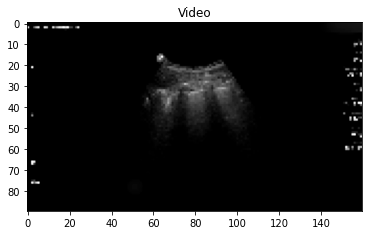

In [28]:
ani = plot_video(example_data[1][1])
HTML(ani.to_html5_video())

In [ ]:
for epoch in range(30):
    # for local_batch in train_loader:
    for labels, local_batch in train_loader:
        local_batch = local_batch.to(device)
        t1 = time.perf_counter()
        activations = model(local_batch)
        t2 = time.perf_counter()
        loss = sparse_layer.loss(local_batch, activations)
        print('epoch={}, loss={:.2f}, time={:.2f}'.format(epoch, loss, t2-t1))

        filter_optimizer.zero_grad()
        loss.backward()
        filter_optimizer.step()
        sparse_layer.normalize_weights()

epoch=0, loss=3195.18, time=7.93
epoch=0, loss=2504.36, time=7.91
epoch=0, loss=1761.99, time=7.91
epoch=0, loss=1557.39, time=7.90
epoch=0, loss=1429.20, time=7.92
epoch=0, loss=1367.57, time=7.91
epoch=0, loss=1332.81, time=7.90
epoch=0, loss=1532.51, time=7.91
epoch=0, loss=1110.26, time=7.90
epoch=0, loss=1123.27, time=7.91
epoch=0, loss=1282.29, time=3.98
epoch=1, loss=1243.19, time=7.89
epoch=1, loss=1183.04, time=7.91
epoch=1, loss=1220.67, time=7.91
epoch=1, loss=1030.79, time=7.92
epoch=1, loss=989.02, time=7.91
epoch=1, loss=1219.97, time=7.93
epoch=1, loss=1268.89, time=7.93


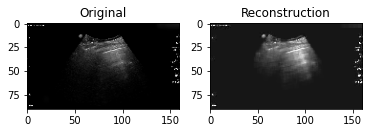

In [36]:
activations = sparse_layer(example_data[1][2:3].to(device))
reconstructions = sparse_layer.reconstructions(
    activations).cpu().detach().numpy()

ani = plot_original_vs_recon(example_data[1][2:3], reconstructions, idx=0)
HTML(ani.to_html5_video())

In [ ]:
ani = plot_filters(sparse_layer.filters.cpu().detach())
HTML(ani.to_html5_video())